In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Parameters

In [2]:
MASSES = [1, 1, 1]
PARTICLES = len(MASSES)
T = 40
T_PLOT = 100
LEARNING_STEPS = 2000

FOURIER_TERMS = 3

LEARNING_RATE = 1e-4

W = ( A_c, A_s, B_c, B_s ) are matrices that stole in the entry (i,j) the j-fourier coefficient of the particle i 

In [3]:
def position (W, i, t):
    
    A_c, A_s, B_c, B_s = W
    
    pos_x, pos_y = 0, 0
    
    for k in range(FOURIER_TERMS + 1):
        
        pos_x += A_c[i, k] * np.cos( k * t ) + A_s[i, k] * np.sin( k * t )
        pos_y += B_c[i, k] * np.cos( k * t ) + B_s[i, k] * np.sin( k * t )
        
    return np.array([pos_x, pos_y])

def speed(W, i, t):
    
    A_c, A_s, B_c, B_s = W
    
    vel_x, vel_y = 0, 0
    
    for k in range(FOURIER_TERMS + 1):
        
        vel_x += k * ( - A_c[i, k] * np.sin( k * t ) + A_s[i, k] * np.cos( k * t ) )
        vel_y += k * ( - B_c[i, k] * np.sin( k * t ) + B_s[i, k] * np.cos( k * t ) )
        
    return np.array([vel_x, vel_y])
        
def action (W):
    
    S = 0
    
    for t in range(T):
        
        time = 2 * t * np.pi / T
        
        for i in range(PARTICLES):
            
            S += ( MASSES[i] / 2 ) * np.linalg.norm( speed(W, i, time) ) ** 2
            
            for j in range(i + 1, PARTICLES):
                
                S += MASSES[i] * MASSES[j] / ( np.linalg.norm( position(W, i, time) 
                                                             - position(W, j, time) ) )
        
    return S * ( 2 * np.pi / T )
    
def ploteo_trayectorias (W, show=True):
    
    for i in range(PARTICLES):
    
        pos_x, pos_y = [], []
    
        for t in range(T_PLOT):
            
            pos = position(W, i , 2 * t * np.pi / T_PLOT)
            pos_x.append( pos[0] )
            pos_y.append( pos[1] )
            
                        
            plt.scatter(pos[0], pos[1], alpha = float(t / T_PLOT), c = "C" + str(i+1), s = 50 * MASSES[i] )
        
        plt.plot(pos_x, pos_y, "-", c="black", lw = 1)
        
    plt.axis("equal")
    plt.axis('off')
    if show:
        plt.show()
    
def frames_trayectoria (W):
    
    pos_x , pos_y = {}, {}
    
    for i in range(PARTICLES):

        pos_x[i], pos_y[i] = [], []

        for t in range(T_PLOT):

            pos = position(W, i , 2 * t * np.pi / T_PLOT)
            pos_x[i].append( pos[0] )
            pos_y[i].append( pos[1] )

        plt.plot(pos_x[i], pos_y[i], "-", c="black", lw = 1)

    
    for t in range(T_PLOT):
        plt.close()
        
        for i in range(PARTICLES):
        
            plt.plot(pos_x[i], pos_y[i], "-", c="C" + str(i+1), lw = 1)
            plt.scatter( pos_x[i][t], pos_y[i][t], c = "C" + str(i+1), s = 50 * MASSES[i] )

        minimo_x = min([ min(pos_x[i]) for i in range(PARTICLES) ])
        maximo_x = max([ max(pos_x[i]) for i in range(PARTICLES) ])
        minimo_y = min([ min(pos_y[i]) for i in range(PARTICLES) ])
        maximo_y = max([ max(pos_y[i]) for i in range(PARTICLES) ])
            
        plt.axis("equal")
        plt.axis('off')
        plt.xlim( [ minimo_x - 0.1 * (maximo_x-minimo_x) , maximo_x + 0.1 * (maximo_x-minimo_x) ] ) 
        plt.ylim( [ minimo_y - 0.1 * (maximo_y-minimo_y) , maximo_y + 0.1 * (maximo_y-minimo_y) ] ) 
        fig = plt.gcf()
        fig.savefig("step"+str(t)+".png", format = "png")
                    
    
def grad (W, actualize_bias = False):

    grad_Ac = np.zeros( ( PARTICLES, FOURIER_TERMS + 1 ) )
    grad_As = np.zeros( ( PARTICLES, FOURIER_TERMS + 1 ) )
    grad_Bc = np.zeros( ( PARTICLES, FOURIER_TERMS + 1 ) )
    grad_Bs = np.zeros( ( PARTICLES, FOURIER_TERMS + 1 ) )

    for t in range(T):
        
        time = 2 * t * np.pi / T
        
        for i in range( PARTICLES ):
            
            pos_i = position(W, i, time )
            vel_i = speed(W, i, time )
            
            for k in range( FOURIER_TERMS + 1 ):

                if k == 0 and not actualize_bias:    
                    continue
                                
                grad_Ac [i, k] += - MASSES[i] * vel_i[0] * np.sin( k * time ) * k
                grad_As [i, k] += + MASSES[i] * vel_i[0] * np.cos( k * time ) * k
                grad_Bc [i, k] += - MASSES[i] * vel_i[1] * np.sin( k * time ) * k
                grad_Bs [i, k] += + MASSES[i] * vel_i[1] * np.cos( k * time ) * k

                for j in range( PARTICLES ):
                    
                    if j == i:
                        continue
                    
                    pos_j = position(W, j, time)
                    vel_j = speed(W, j, time)
                    
                    grad_Ac [i, k] += - MASSES[i] * MASSES[j]   \
                                        / ( np.linalg.norm( pos_i - pos_j ) ** 3 ) \
                                        * ( pos_i[0] - pos_j[0] ) \
                                        * np.cos( k * time )
                    grad_As [i, k] += - MASSES[i] * MASSES[j]   \
                                        / ( np.linalg.norm( pos_i - pos_j ) ** 3 ) \
                                        * ( pos_i[0] - pos_j[0] ) \
                                        * np.sin( k * time )
                    grad_Bc [i, k] += - MASSES[i] * MASSES[j]   \
                                        / ( np.linalg.norm( pos_i - pos_j ) ** 3 ) \
                                        * ( pos_i[1] - pos_j[1] ) \
                                        * np.cos( k * time )
                    grad_Bs [i, k] += - MASSES[i] * MASSES[j]   \
                                        / ( np.linalg.norm( pos_i - pos_j ) ** 3 ) \
                                        * ( pos_i[1] - pos_j[1] ) \
                                        * np.sin( k * time )
                                
                    
    return np.array([grad_Ac, grad_As, grad_Bc, grad_Bs])

def initialization( PARTICLES, FOURIER_TERMS, mode = "RANDOM", density = 1.0, decay = 0.0 ):
    
    if mode == "ZEROS":
        
        A_c_0 = np.zeros( ( PARTICLES , FOURIER_TERMS + 1 ) ) 
        A_s_0 = np.zeros( ( PARTICLES , FOURIER_TERMS + 1 ) ) 
        B_c_0 = np.zeros( ( PARTICLES , FOURIER_TERMS + 1 ) ) 
        B_s_0 = np.zeros( ( PARTICLES , FOURIER_TERMS + 1 ) ) 


    if mode == "RANDOM":
        
        A_c_0 = np.random.normal( size = ( PARTICLES , FOURIER_TERMS + 1 ) ) 
        A_s_0 = np.random.normal( size = ( PARTICLES , FOURIER_TERMS + 1 ) ) 
        B_c_0 = np.random.normal( size = ( PARTICLES , FOURIER_TERMS + 1 ) ) 
        B_s_0 = np.random.normal( size = ( PARTICLES , FOURIER_TERMS + 1 ) ) 

    if density < 1.0:
        
        A_c_0[ np.random.random( A_c_0.shape ) > density ] = 0
        A_s_0[ np.random.random( A_s_0.shape ) > density ] = 0
        B_c_0[ np.random.random( B_c_0.shape ) > density ] = 0
        B_s_0[ np.random.random( B_s_0.shape ) > density ] = 0

    if decay > 0 :
        
        factor = np.array( [0] + [ k ** ( - decay)  for k in range( 1,  FOURIER_TERMS + 1 ) ] )
        A_c_0 = A_c_0 * factor
        A_s_0 = A_s_0 * factor
        B_c_0 = B_c_0 * factor
        B_s_0 = B_s_0 * factor
    
    A_c_0[:,0] = np.zeros((PARTICLES))
    A_s_0[:,0] = np.zeros((PARTICLES))
    B_c_0[:,0] = np.zeros((PARTICLES))
    B_s_0[:,0] = np.zeros((PARTICLES))
        
    return np.array([ A_c_0, A_s_0, B_c_0, B_s_0 ])

## Gradient descent

---------------------


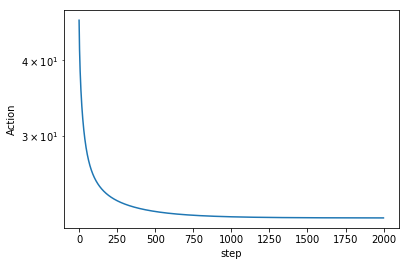

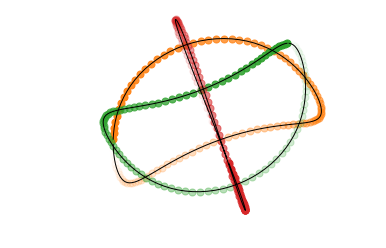

---------------------


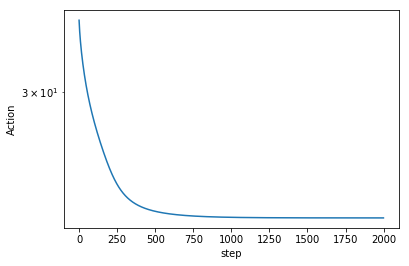

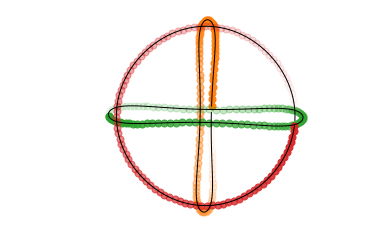

---------------------


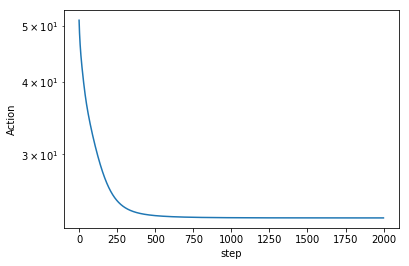

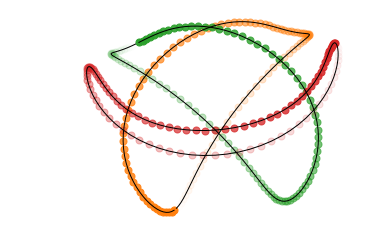

---------------------


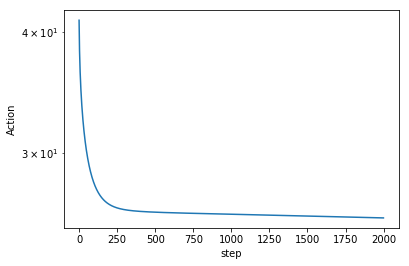

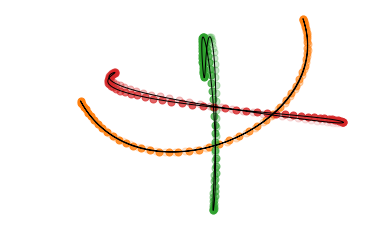

---------------------


In [ ]:
NUMBER_EXPERIMENTS = 10

for ii in range(NUMBER_EXPERIMENTS):

    print("---------------------")
    
    try:
    
        W_0 = initialization( PARTICLES, FOURIER_TERMS, mode = "RANDOM", density=0.3, decay = 1)
        W = W_0 
        W_best = W_0
        S_best = np.inf
        S_improvement = []

        for step in range(LEARNING_STEPS):

            grad_W = grad(W)

            W -= LEARNING_RATE * grad_W

            S = action(W)
            S_improvement.append( S )

            if S < S_best:
                W_best = W

            final_step = step


        plt.close()
        plt.semilogy( range(len(S_improvement)), S_improvement )
        plt.xlabel("step")
        plt.ylabel("Action")
        plt.show()
        
        plt.close()
        ploteo_trayectorias(W, show=True)
        

    except:
        pass